Aspectos que se abordan en estos ejercicios:

    - Algoritmo Support Vector Machine (SVM)
    - Búsqueda de hiperparámetros óptimos con grid search
    - Búsqueda de hiperparámetros óptimos con búsqueda aleatoria
    - Creación de pipelines de preparación de datos y entrenamiento del modelo

In [191]:
import os
import tarfile
from six.moves import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, \
cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, \
MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib #from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [2]:
HOUSING_PATH = os.path.join("../..", "datasets", "housing")

In [7]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
housing_df = load_housing_data()
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],
                                 bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                                 labels=[1, 2, 3, 4, 5])

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [11]:
train_set = strat_train_set.drop("median_house_value", axis=1)
train_labels = strat_train_set["median_house_value"].copy()

In [12]:
test_set = strat_test_set.copy()
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [26]:
test_labels = test_set["median_house_value"].copy()

In [13]:
housing_num = train_set.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)

In [14]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): # herencia de clases
    ## BaseEstimator --> get_params(), set_params()
    ## TransformerMinin --> fit_transform()
    ## duck typing para pipelines
    def __init__(self, add_bedrooms_per_room = True): # no incluir *args o **Kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [48]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

num_attribs = list(train_set.drop('ocean_proximity', axis=1))
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [16]:
housing_prepared = full_pipeline.fit_transform(train_set)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
housing_prepared.shape

(16512, 16)

In [ ]:
# Puntuaciones de los atributos estimados en el temario del capítulo 2 con el algoritmo Random Forests 
feature_importances = grid_search.best_estimator_.feature_importances_

In [18]:
feature_importances = np.array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [19]:
# Lista de atributos finales obtenidos con el pipeline de preparación de datos
attributes = num_attribs + \
            ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"] + \
            list(full_pipeline.named_transformers_["cat"].categories_[0])

#### Exercise 1
Utilizar el algoritmo Support Vector Machine (SVM) y el grid search para encontrar una combinación de parámetros idónea

In [22]:
from sklearn.svm import SVR

In [ ]:
param_grid = [
    {'kernel': ["linear"], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {'kernel': ["rbf"], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=2)

grid_search.fit(housing_prepared, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=  19.3s
[CV] END ..............................C=10.0, kernel=linear; total time=  20.1s
[CV] END ..............................C=10.0, kernel=linear; total time=  19.0s
[CV] END ..............................C=10.0, kernel=linear; total time=  19.7s
[CV] END ..............................C=10.0, kernel=linear; total time=  19.0s
[CV] END ..............................C=30.0, kernel=linear; total time=  19.6s
[CV] END ..............................C=30.0, kernel=linear; total time=  19.1s
[CV] END ..............................C=30.0, kernel=linear; total time=  19.5s
[CV] END ..............................C=30.0, kernel=linear; total time=  18.8s
[CV] END ..............................C=30.0, kernel=linear; total time=  19.6s
[CV] END .............................C=100.0, kernel=linear; total time=  19.0s
[CV] END .............................C=100.0, 

[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  18.1s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  17.8s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  18.7s
[CV] END .....................C=10.0, gamma=0.01, kernel=rbf; total time=  17.9s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  19.1s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  17.6s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  17.9s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  18.3s
[CV] END .....................C=10.0, gamma=0.03, kernel=rbf; total time=  16.8s
[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=  16.1s
[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=  17.8s
[CV] END ......................C=10.0, gamma=0.1, kernel=rbf; total time=  17.5s
[CV] END ...................

[CV] END .....................C=300.0, gamma=0.1, kernel=rbf; total time=  16.4s
[CV] END .....................C=300.0, gamma=0.1, kernel=rbf; total time=  16.8s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  16.1s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  19.6s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  16.7s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  15.6s
[CV] END .....................C=300.0, gamma=0.3, kernel=rbf; total time=  15.8s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  15.5s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  15.4s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  16.3s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  17.0s
[CV] END .....................C=300.0, gamma=1.0, kernel=rbf; total time=  15.5s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [ ]:
grid_search.best_estimator_

SVR(C=30000.0, kernel='linear')

In [ ]:
rsme = np.sqrt(-grid_search.best_score_)
rsme

70286.61836530612

#### Exercise 2
Reemplazar el grid search por una búsqueda aleatoria

In [197]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal # distribuciones de probabilidad

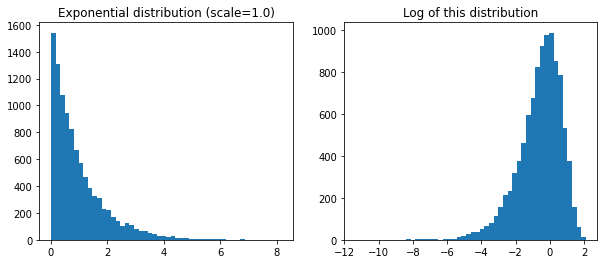

In [198]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

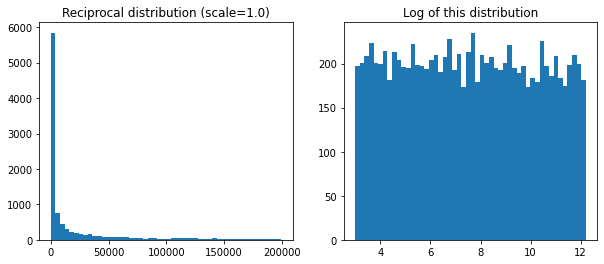

In [201]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
# La distribución recíproca resulta útil cuando no se sabe cuál debería ser la escala del hiperparámetro
# (en el gráfico de la derecha se ve que todas las escalas son igualmente probables).
# La distribución exponencial cuando se sabe aproximádamente cuál debería ser la escala del hiperparámetro.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)

rnd_search.fit(housing_prepared, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.5s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   9.5s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  17.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  17.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.6s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  18.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  17.9s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  15.7s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  16.3s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  15.5s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.7s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.4s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.5s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.9s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   9.5s
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.6min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.6min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.6min
[CV] END C=151136.2028

[CV] END C=60.17373642891687, gamma=1.2491263443165994, kernel=linear; total time=   8.8s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  16.1s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  15.8s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  16.6s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  16.0s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  15.9s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   9.1s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   9.5s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   9.5s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   9.0s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   9.1s
[CV] END C=55.538389

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024299EFD788>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002428A23B1C8>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# La búsqueda aleatoria tiene a encontrar mejores hiperparámetros que el grid search en el mismo tiempo
rnd_search.best_estimator_

SVR(C=157055.10989448498, gamma=0.26497040005002437)

In [ ]:
rsme = np.sqrt(-rnd_search.best_score_)
rsme

54751.69009256622

#### Exercise 3
Añadir un transformer al pipeline de preparación de datos para seleccionar los mejores atributos

In [20]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
k=5

In [ ]:
select_top_attr = TopFeatureSelector(feature_importances, k)
select_top_attr.fit(housing_prepared)
select_top_attr.transform(housing_prepared)

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604,  0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083,  1.        ]])

In [ ]:
select_top_attr = TopFeatureSelector(feature_importances, k)
select_top_attr.fit_transform(full_pipeline.fit_transform(train_set))

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604,  0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083,  1.        ]])

In [ ]:
np.array(attributes)[select_top_attr.feature_indices_]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [ ]:
pd.DataFrame(select_top_attr.transform(housing_prepared), columns=np.array(attributes)[select_top_attr.feature_indices_])

,longitude,latitude,median_income,pop_per_hhold,INLAND
0,-0.941350,1.347438,-0.893647,0.006223,1.0
1,1.171782,-1.192440,1.292168,-0.040811,0.0
2,0.267581,-0.125972,-0.525434,-0.075371,1.0
3,1.221738,-1.351474,-0.865929,-0.106803,0.0
4,0.437431,-0.635818,0.325752,0.006109,0.0
...,...,...,...,...,...
16507,1.251711,-1.220505,0.637374,-0.092580,0.0
16508,-0.921368,1.342761,-0.557509,0.023024,1.0
16509,-1.570794,1.310018,-0.365475,-0.037436,0.0
16510,-1.560803,1.249211,0.168261,-0.059156,0.0


In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.366158981, 'median_income'),
 (0.164780994, 'INLAND'),
 (0.108792957, 'pop_per_hhold'),
 (0.0733442355, 'longitude'),
 (0.0629090705, 'latitude')]

In [ ]:
np.array(attributes)[select_top_attr.feature_indices_]

array([['0.36615898061813423', 'median_income'],
       ['0.16478099356159054', 'INLAND'],
       ['0.04114379847872964', 'housing_median_age'],
       ['0.014672685420543239', 'total_rooms'],
       ['0.010311488326303788', '<1H OCEAN']], dtype='<U32')

In [ ]:
preparation_pipeline = Pipeline([
    ('feature_preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k=5))
])

In [ ]:
housing_top_prepared  = preparation_pipeline.fit_transform(train_set)
housing_top_prepared

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604,  0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083,  1.        ]])

In [ ]:
housing_top_prepared[:3]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

In [ ]:
housing_prepared[:3, preparation_pipeline.steps[1][1].feature_indices_]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

#### Execise 4
Crear un pipeline que realice la preparación de los datos y la predicción

In [52]:
complete_pipeline = Pipeline([
    ('feature_preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k=5)),
    ('train_model', SVR(C=157055.10989448498, gamma=0.26497040005002437)) #SVR(**rnd_search.best_estimator_)
])

In [56]:
complete_pipeline.fit(train_set, train_labels)

Pipeline(steps=[('feature_preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                  

In [33]:
sample_data = test_set.iloc[:4]
sample_labels = test_labels.iloc[:4]

print("Predictions:\t", complete_pipeline.predict(sample_data))
print("Labels:\t\t", list(sample_labels))

Predictions:	 [476943.83358636 245388.88803267 223879.87382943 181959.39131938]
Labels:		 [500001.0, 162500.0, 204600.0, 159700.0]


#### Excercise 5
Explorar opciones para la preparación de los datos con grid search

In [44]:
# Evita que aparezcan warnings durante el entrenamiento (de forma 
# predeterminada, handle_unknown='error'). Por defecto, generaría un error al
# transformar cualquier dato que contuviera una categoría que no vió durante el
# entrenamiento. GridSearch tendría errores durante el entramiento al evaluar
# los folds en los que no todas las categorías están en el conjunto de
# entrenamiento. En este conjunto de datos es probable que suceda ya que solo
# hay una muestra en la categoría 'ISLAND' y puede terminar en el conjunto de
# prueba en algunos folds. Debido a esto, GridSearchCV elimina algunos folds.
# Modificando este hiperparámetro se evita esta circunstancia.

full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore' # No ha omitido los warnings

param_grid = [{
    # cuidado con los nombres. En el pipeline completo, el nombre que hace
    # referencia al pipeline de transformaciones es feature_preparation, por lo
    # que el prefijo del nombre correspondiente en el param_grid debe ser
    # exactamente igual, feature_preparation.... Lo mismo ocurre para el nombre
    # correspondiente con la selección de atributos, feature_selection. 
    'feature_preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], # hiperparámetro strategy de imputer
    'feature_selection__k': list(range(1, len(feature_importances) + 1)) # hiperparámetro k de selección de atributos
    # no hay más parámetros a configurar en este pipeline
}]

grid_search_prep = GridSearchCV(complete_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)

grid_search_prep.fit(train_set, train_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   8.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   8.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   8.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.4s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.6s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   8.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  11.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  11.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  11.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  10.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   9.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  11.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  10.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  11.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   8.8s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  11.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  11.0s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  11.3s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   9.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  11.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  11.4s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  11.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  11.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   9.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  11.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  11.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  11.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  11.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   8.9s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  11.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  11.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  11.2s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  11.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   9.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.9s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   9.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   9.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   9.7s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  12.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  12.0s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  11.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   9.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  12.2s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  12.0s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  12.4s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  12.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  10.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.4s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.0s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.0s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  10.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.4s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.6s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  10.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.2s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.6s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  10.2s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  13.1s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.5s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  10.5s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.4s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.2s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  12.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  10.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.3s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.2s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.3s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  10.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  12.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.0s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  13.7s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  14.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  14.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  15.0s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  14.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  13.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  14.4s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  15.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  15.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  15.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  12.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  15.2s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  14.6s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  16.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  15.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  16.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  18.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  19.4s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  19.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  18.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  15.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  19.4s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  18.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  18.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  19.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  14.1s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  19.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  18.4s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  17.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  19.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  18.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  22.3s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  19.5s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  21.7s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  20.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  20.1s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  21.5s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  20.0s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  22.4s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  20.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  21.2s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  22.0s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  21.5s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  22.2s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  23.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  21.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  24.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  24.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  24.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  22.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  22.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  23.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  23.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  25.1s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  21.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  21.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  20.5s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  25.6s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  23.8s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  22.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  20.2s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  26.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  26.6s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  25.8s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  23.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  23.1s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  25.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  22.6s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  21.8s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  25.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  24.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  25.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  27.8s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  23.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  26.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  24.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  24.2s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  26.4s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  28.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  23.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  25.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  28.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  23.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  28.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  27.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noq

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  25.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  23.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  27.6s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  24.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  24.4s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=   0.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  25.8s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  28.6s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  27.1s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  28.5s
[CV] 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", line 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
             

In [40]:
grid_search_prep.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__feature_preparation', 'estimator__feature_selection', 'estimator__train_model', 'estimator__feature_preparation__n_jobs', 'estimator__feature_preparation__remainder', 'estimator__feature_preparation__sparse_threshold', 'estimator__feature_preparation__transformer_weights', 'estimator__feature_preparation__transformers', 'estimator__feature_preparation__verbose', 'estimator__feature_preparation__verbose_feature_names_out', 'estimator__feature_preparation__num', 'estimator__feature_preparation__cat', 'estimator__feature_preparation__num__memory', 'estimator__feature_preparation__num__steps', 'estimator__feature_preparation__num__verbose', 'estimator__feature_preparation__num__imputer', 'estimator__feature_preparation__num__attribs', 'estimator__feature_preparation__num__std_scaler', 'estimator__feature_preparation__num__imputer__add_indicator', 'estimator__feature_preparation__num__

In [ ]:
grid_search_prep.best_params_